In [1]:
!pip install xgboost shap seaborn --quiet


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import xgboost as xgb
import shap
import joblib
from IPython.display import display

In [3]:
OUTPUT_DIR = "/content/armos_classification_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
CSV_NAME = "features_for_ml_realistic_v2.csv"

In [4]:
np.random.seed(2025)
n_samples = 5000

In [5]:
class_probs = {0:0.55,1:0.3,2:0.15}  # Humans, Bots, LLMs
labels = np.random.choice([0,1,2], size=n_samples, p=list(class_probs.values()))
rows = []

for i in range(n_samples):
    cls = labels[i]

    if cls == 0:  # Human
        header_count = int(np.random.normal(15,3))
        ua_entropy = np.random.normal(4.0,0.7)
        missing_headers = np.random.binomial(1,0.1)
        referer_flag = np.random.binomial(1,0.85)
        avg_interarrival = np.clip(np.random.normal(1.2,0.6),0.05,None)
        endpoint_diversity = int(np.random.poisson(3))
        burst_score = np.clip(np.random.beta(1,6),0,1)
        form_submission_rate = np.clip(np.random.beta(2,8),0,1)
        ja3_hash_similarity = np.clip(np.random.beta(5,2),0,1)
        ja3_entropy = np.random.normal(3.5,0.5)
        ASN_score = np.clip(np.random.beta(1.5,6),0,1)
        geo_distance = np.random.exponential(100)
        ip_reputation_score = np.random.normal(10,8)
        vt_flag = np.random.binomial(1,0.01)
        shodan_hosting_type = np.random.choice([0,1,2], p=[0.85,0.10,0.05])
        honeypot_triggered = 0
        trap_depth = 0
        fake_endpoint_interaction = 0
        total_risk_score = np.clip(np.random.normal(0.05,0.05),0,1)
        anomaly_score = np.clip(np.random.normal(0.02,0.03),0,1)
        avg_session_length = np.random.exponential(120)+30

    elif cls == 1:  # Bot
        header_count = int(np.random.normal(10,4))
        ua_entropy = np.random.normal(2.5,0.8)
        missing_headers = np.random.binomial(2,0.35)
        referer_flag = np.random.binomial(1,0.45)
        avg_interarrival = np.clip(np.random.normal(0.25,0.25),0.01,None)
        endpoint_diversity = int(np.random.poisson(9))
        burst_score = np.clip(np.random.beta(4,2),0,1)
        form_submission_rate = np.clip(np.random.beta(1,8),0,1)
        ja3_hash_similarity = np.clip(np.random.beta(2,3),0,1)
        ja3_entropy = np.random.normal(2.2,0.6)
        ASN_score = np.clip(np.random.beta(4,2),0,1)
        geo_distance = np.random.exponential(400)
        ip_reputation_score = np.random.normal(45,20)
        vt_flag = np.random.binomial(1,0.05)
        shodan_hosting_type = np.random.choice([0,1,2], p=[0.1,0.75,0.15])
        honeypot_triggered = np.random.binomial(1,0.05)
        trap_depth = np.random.randint(0,3)
        fake_endpoint_interaction = np.random.binomial(1,0.02)
        total_risk_score = np.clip(np.random.normal(0.45,0.2),0,1)
        anomaly_score = np.clip(np.random.normal(0.35,0.2),0,1)
        avg_session_length = np.random.exponential(40)+5

    else:  # LLM
        header_count = int(np.random.normal(13,3))
        ua_entropy = np.random.normal(3.4,0.6)
        missing_headers = np.random.binomial(1,0.2)
        referer_flag = np.random.binomial(1,0.6)
        avg_interarrival = np.clip(np.random.normal(0.5,0.4),0.01,None)
        endpoint_diversity = int(np.random.poisson(12))
        burst_score = np.clip(np.random.beta(2,3),0,1)
        form_submission_rate = np.clip(np.random.beta(1.5,6),0,1)
        ja3_hash_similarity = np.clip(np.random.beta(2.5,3),0,1)
        ja3_entropy = np.random.normal(2.5,0.5)
        ASN_score = np.clip(np.random.beta(3,3),0,1)
        geo_distance = np.random.exponential(600)
        ip_reputation_score = np.random.normal(30,25)
        vt_flag = np.random.binomial(1,0.02)
        shodan_hosting_type = np.random.choice([0,1,2], p=[0.5,0.35,0.15])
        honeypot_triggered = np.random.binomial(1,0.12)
        trap_depth = np.random.randint(0,5)
        fake_endpoint_interaction = np.random.binomial(1,0.05)
        total_risk_score = np.clip(np.random.normal(0.35,0.18),0,1)
        anomaly_score = np.clip(np.random.normal(0.25,0.15),0,1)
        avg_session_length = np.random.exponential(80)+20

    rows.append({
        "header_count":header_count,
        "ua_entropy":ua_entropy,
        "missing_headers":missing_headers,
        "referer_flag":referer_flag,
        "avg_interarrival":avg_interarrival,
        "endpoint_diversity":endpoint_diversity,
        "burst_score":burst_score,
        "form_submission_rate":form_submission_rate,
        "ja3_hash_similarity":ja3_hash_similarity,
        "ja3_entropy":ja3_entropy,
        "ASN_score":ASN_score,
        "geo_distance":geo_distance,
        "ip_reputation_score":ip_reputation_score,
        "vt_flag":vt_flag,
        "shodan_hosting_type":shodan_hosting_type,
        "honeypot_triggered":honeypot_triggered,
        "trap_depth":trap_depth,
        "fake_endpoint_interaction":fake_endpoint_interaction,
        "total_risk_score":total_risk_score,
        "anomaly_score":anomaly_score,
        "avg_session_length":avg_session_length,
        "label":cls
    })

df = pd.DataFrame(rows)

In [6]:
import numpy as np

np.random.seed(2025)

# 1. Increase hybrid overlap: 20% of dataset
n_hybrid = int(0.2 * len(df))
hybrid_idx = np.random.choice(df.index, n_hybrid, replace=False)

for i in hybrid_idx:
    cls = df.loc[i, "label"]

    # Humans partially look like Bots or LLMs
    if cls == 0:
        df.loc[i, "ua_entropy"] += np.random.normal(0, 1.0)
        df.loc[i, "anomaly_score"] += np.random.uniform(0.15, 0.4)
        df.loc[i, "ja3_hash_similarity"] -= np.random.uniform(0.1,0.3)

    # Bots partially look like Humans or LLMs
    elif cls == 1:
        df.loc[i, "avg_interarrival"] += np.random.normal(0.5,0.3)
        df.loc[i, "burst_score"] -= np.random.uniform(0.1,0.3)
        df.loc[i, "total_risk_score"] -= np.random.uniform(0.05,0.2)

    # LLMs partially look like Humans or Bots
    elif cls == 2:
        df.loc[i, "form_submission_rate"] += np.random.uniform(-0.1,0.2)
        df.loc[i, "ua_entropy"] += np.random.normal(0,0.5)
        df.loc[i, "anomaly_score"] += np.random.uniform(-0.1,0.2)

# 2. Reduce informativeness of strongest features
strong_features = ["ua_entropy","ja3_hash_similarity","anomaly_score","burst_score"]
for f in strong_features:
    noise = np.random.normal(0, df[f].std() * 0.4, len(df))  # larger variance
    df[f] += noise

# 3. Clip features to reasonable ranges
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols:
    df[col] = np.clip(df[col], df[col].min(), df[col].max())

print("✅ Dataset modified to be less predictive.")

✅ Dataset modified to be less predictive.


In [7]:
numeric_cols = df.select_dtypes(include=np.number).columns.drop("label")
for col in numeric_cols:
    df[col] += np.random.normal(0, df[col].std() * 0.15, len(df))


In [8]:
n_hybrids = int(0.1 * len(df))
hybrid_idx = np.random.choice(df.index, n_hybrids, replace=False)
for i in hybrid_idx:
    if df.loc[i, "label"] == 0:  # human->bot
        df.loc[i, "ua_entropy"] += np.random.normal(0.8, 0.3)
        df.loc[i, "anomaly_score"] += np.random.uniform(0.2, 0.4)
    elif df.loc[i, "label"] == 1:  # bot->human
        df.loc[i, "referer_flag"] = np.random.binomial(1, 0.8)
        df.loc[i, "total_risk_score"] -= np.random.uniform(0.1, 0.3)
    else:  # LLM->stealth
        df.loc[i, "ua_entropy"] -= np.random.normal(0.4, 0.2)
        df.loc[i, "ja3_hash_similarity"] += np.random.uniform(0.05, 0.1)

In [9]:
noise_idx = np.random.choice(df.index, int(0.03 * len(df)), replace=False)
df.loc[noise_idx, "label"] = np.random.choice([0,1,2], len(noise_idx))


In [10]:
for col in ["total_risk_score", "honeypot_triggered", "trap_depth", "fake_endpoint_interaction"]:
    df[col] += np.random.normal(0, df[col].std()*0.02, len(df))  # 5% noise
    df[col] = np.clip(df[col], 0, df[col].max())  # keep values realistic

In [11]:
df.to_csv(CSV_NAME, index=False)
print("✅ Dataset generated:", df.shape)

✅ Dataset generated: (5000, 22)


In [12]:
for col in numeric_cols:
    noise_factor = df[col].std() * 0.05  # slightly stronger than before
    df[col] += np.random.normal(0, noise_factor, len(df))

# Swap a small fraction of labels
swap_idx = np.random.choice(df.index, int(0.04*len(df)), replace=False)
df.loc[swap_idx, "label"] = np.random.choice([0,1,2], size=len(swap_idx))

print("✅ Added label swaps and extra noise to reduce predictiveness:", df.shape)

# Then proceed with train-test split and scaling
X = df.drop(columns="label").values
y = df["label"].values

✅ Added label swaps and extra noise to reduce predictiveness: (5000, 22)


In [13]:
labels_dict = {0:"Human",1:"Bot",2:"LLM"}

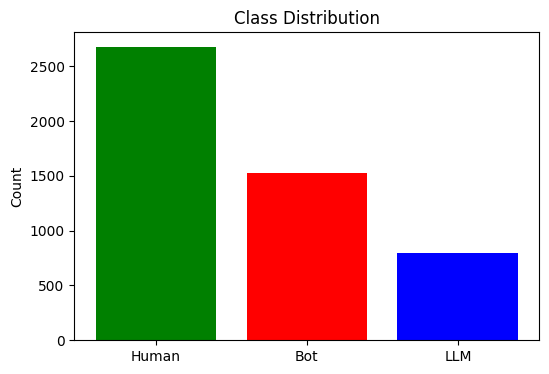

In [14]:
plt.figure(figsize=(6,4))
counts = df.label.value_counts().sort_index()
plt.bar([labels_dict[i] for i in counts.index], counts.values, color=['green','red','blue'])
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()


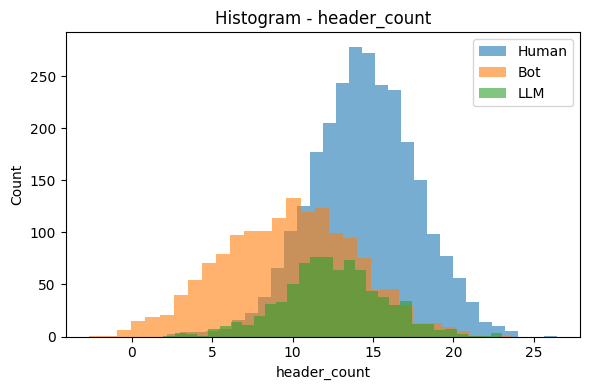

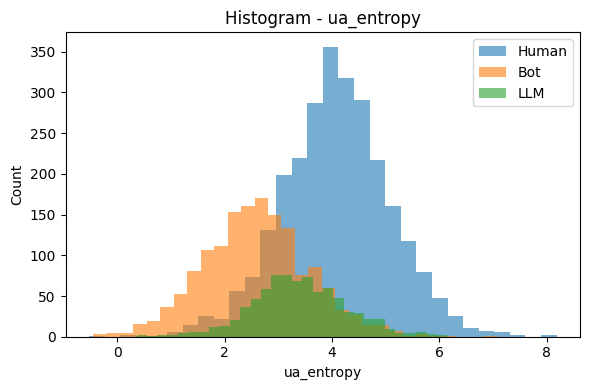

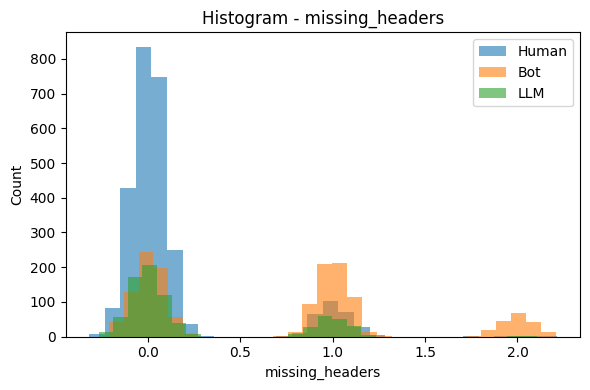

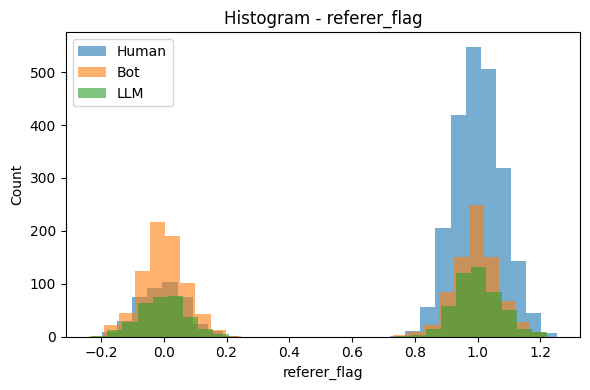

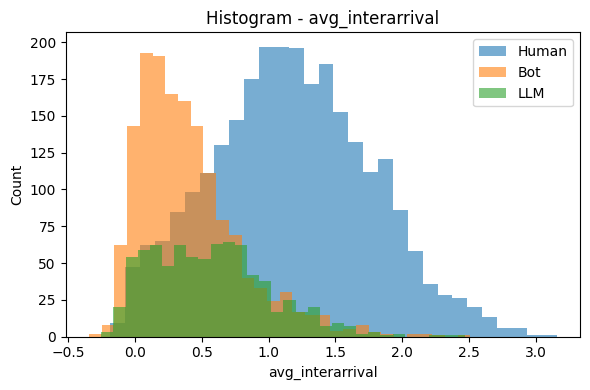

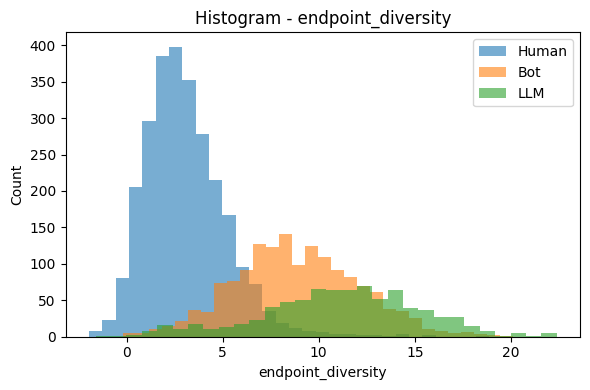

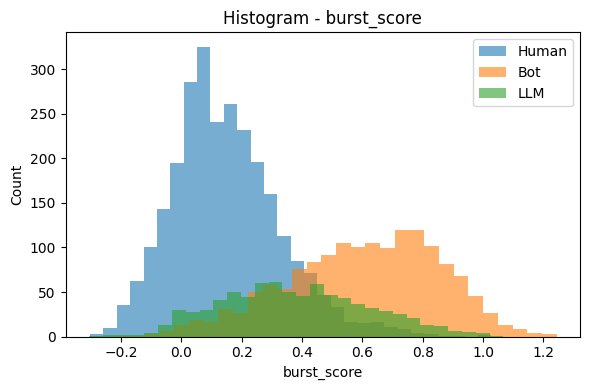

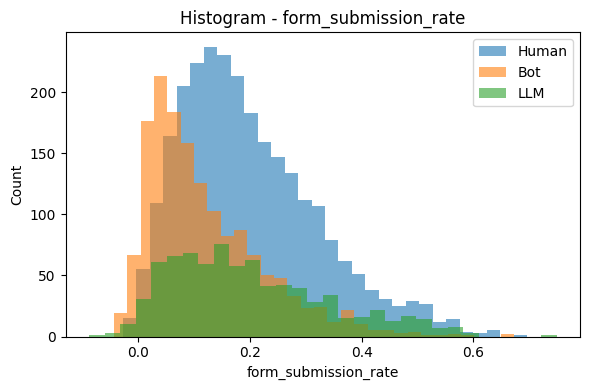

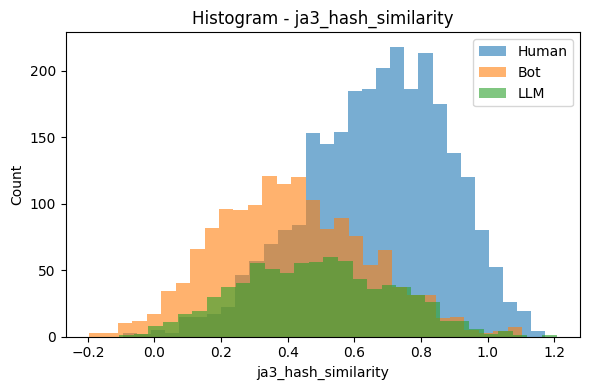

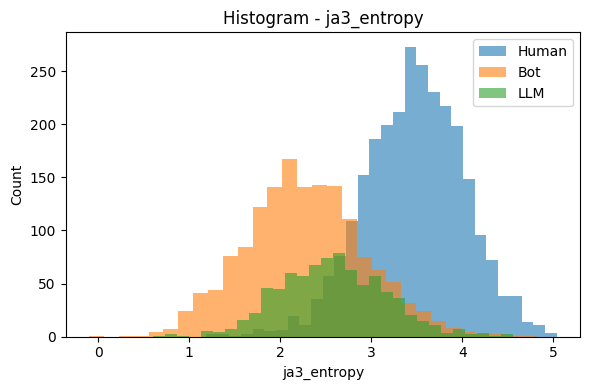

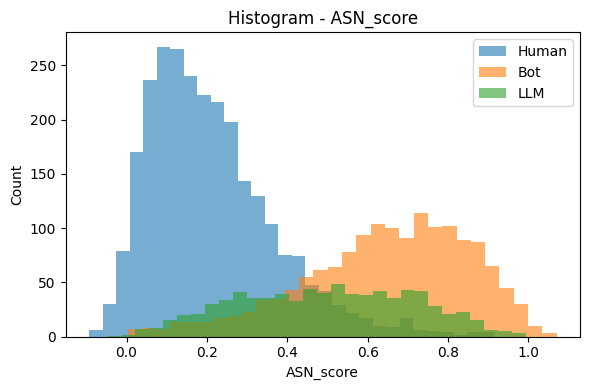

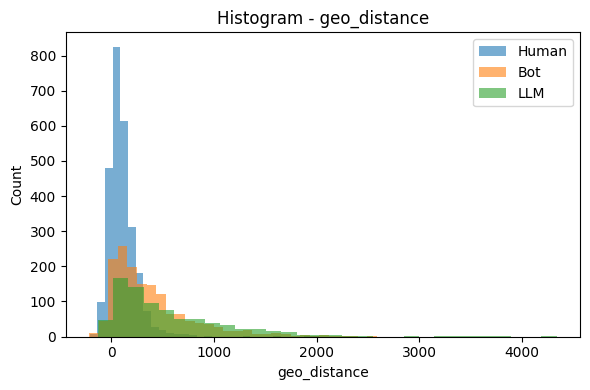

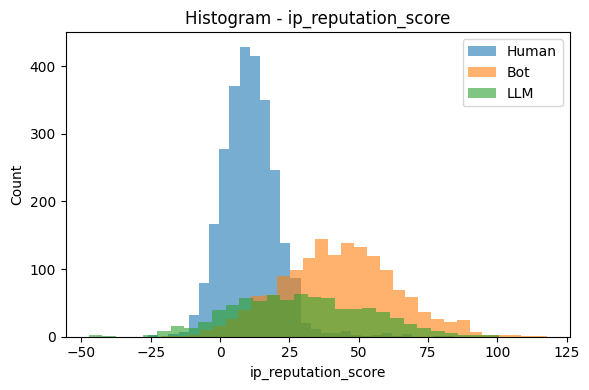

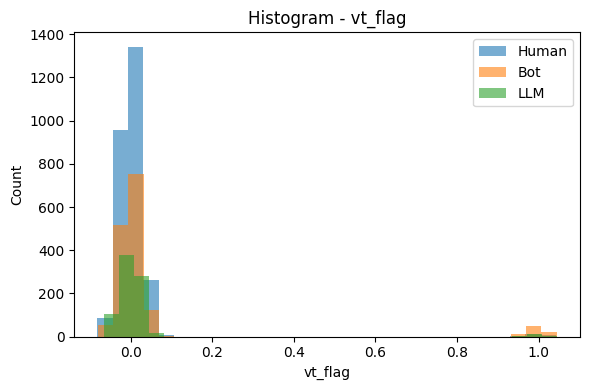

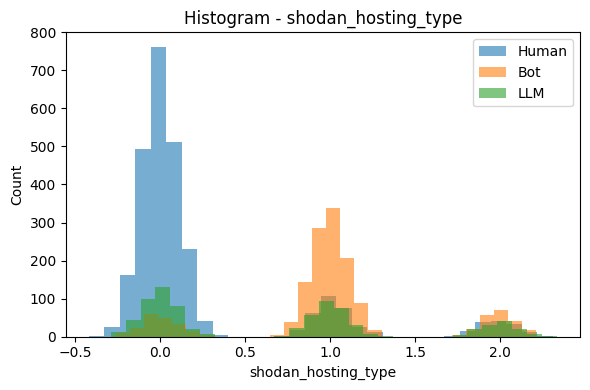

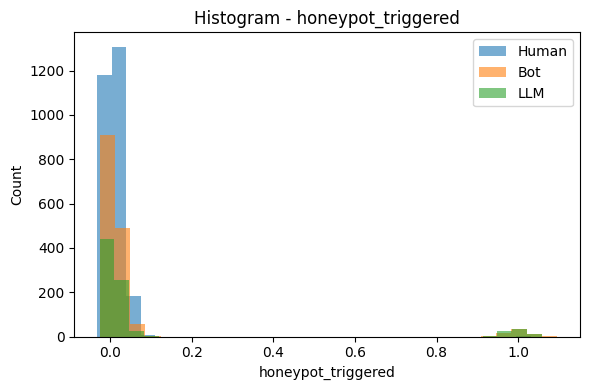

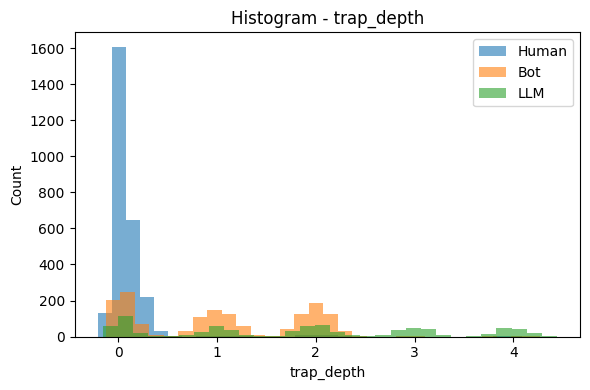

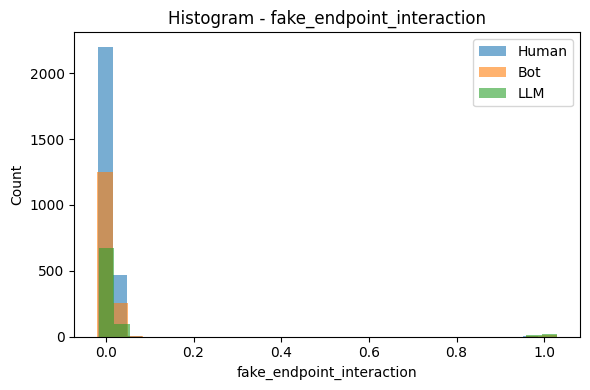

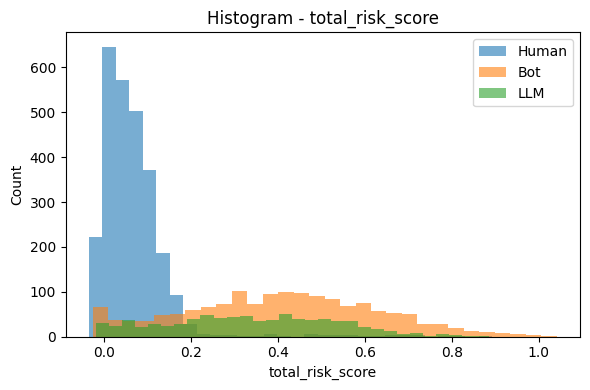

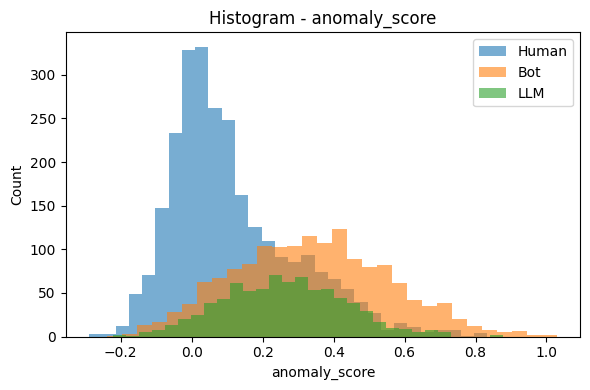

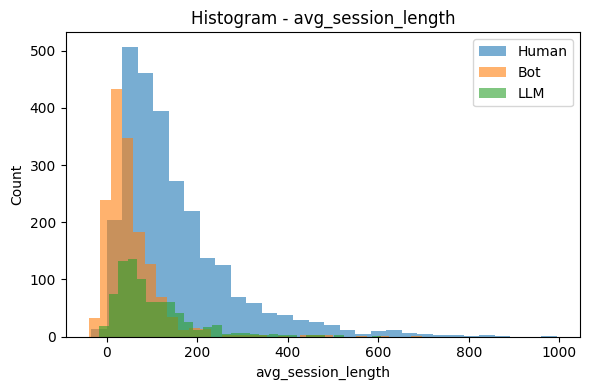

In [15]:
numeric_features = df.columns.drop("label")

for f in numeric_features:
    plt.figure(figsize=(6, 4))
    for cls in [0, 1, 2]:
        plt.hist(
            df[df.label == cls][f],
            bins=30,
            alpha=0.6,
            label=labels_dict[cls]
        )
    plt.title(f"Histogram - {f}")
    plt.xlabel(f)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

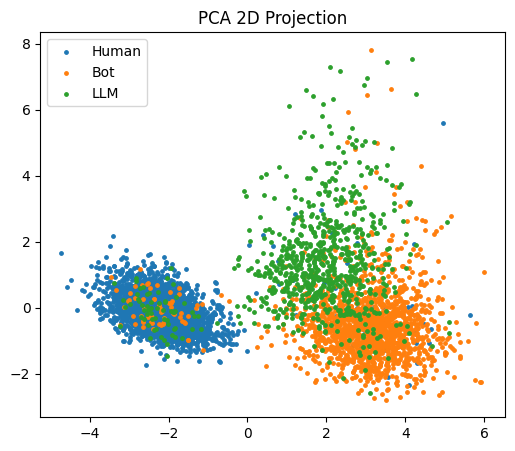

In [16]:
features = df.drop(columns="label")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
for cls in [0,1,2]:
    plt.scatter(X_pca[df.label==cls,0], X_pca[df.label==cls,1], label=labels_dict[cls], s=6)
plt.legend()
plt.title("PCA 2D Projection")
plt.show()


In [17]:
X = features.values
y = df["label"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
import xgboost as xgb
best_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,      # smaller trees
    learning_rate=0.05,
    subsample=0.7,    # use only 70% of samples per tree
    colsample_bytree=0.7,
    reg_alpha=1.0,    # L1 regularization
    reg_lambda=1.5,   # L2 regularization
    gamma=1,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"
)

In [21]:
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Human","Bot","LLM"]))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:36:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Test Accuracy: 0.9070

Classification Report:

              precision    recall  f1-score   support

       Human       0.95      0.97      0.96       535
         Bot       0.87      0.88      0.88       306
         LLM       0.83      0.74      0.78       159

    accuracy                           0.91      1000
   macro avg       0.88      0.86      0.87      1000
weighted avg       0.91      0.91      0.91      1000



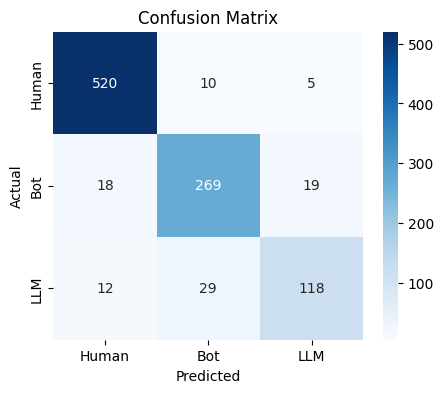

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Human","Bot","LLM"],
            yticklabels=["Human","Bot","LLM"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()